# Mission Analysis and Orbital Mechanics Assignment - Exercise 3
Auxilliary calculation functions can be found in the file solvers_calculators.py

In [2]:
import numpy as np
from constants import *
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### ISS:
- equatorial orbit
- 404 km above the earth
### Chaser:
- apogee = R_ISS
- angular separation = delta_theta
- catches up to ISS in N_rev orbits

In [3]:
R_ISS = R_EARTH + 404  # km
D_THETA = np.radians(100)  # initial angular separation in radians

V_ISS = np.sqrt(G_EARTH / R_ISS)

r0 = np.array([R_ISS * np.cos(D_THETA), R_ISS * np.sin(D_THETA), 0])
v0 = np.array([-V_ISS * np.sin(D_THETA), V_ISS * np.cos(D_THETA), 0])

X0 = np.concatenate((r0, v0))

# 2.5 hours (a bit more than the period)
ts = np.arange(0, 3600 * 2.5, 10)

def solve_for_ts(X0, ts):
    def twobody(_, X):
        return np.concatenate((X[3:], - G_EARTH * X[:3] / np.power(np.linalg.norm(X[:3]), 3)))

    sol = solve_ivp(twobody, [0, np.max(ts)], X0, t_eval=ts, rtol=1e-12, atol=1e-12, vectorized=True)
    return sol.y[:2, :], sol.y[3:5, :]

pos2d, vels2d = solve_for_ts(X0, ts)

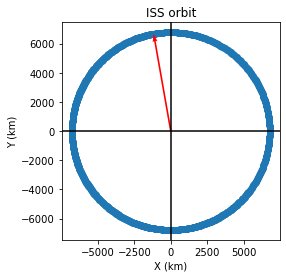

In [4]:
# time vs magnitude of the velocity vector
plt.scatter(*pos2d)
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.title("ISS orbit")
plt.gca().set_aspect('equal')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.quiver(0, 0, *r0[:2], color=['r'], angles='xy', scale_units='xy', scale=1)
plt.show()

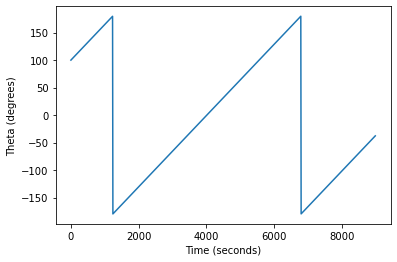

5560.0
5558.375715461923


In [5]:
# theta, measure from x axis CCW
thetas = np.arctan2(pos2d[1, :], pos2d[0, :])

# we can see in the plot that we have less than 2 periods
plt.plot(ts, np.degrees(thetas))
plt.xlabel("Time (seconds)")
plt.ylabel("Theta (degrees)")
plt.show()

# period computation from obtained thetas: time until theta is 100 again
print(ts[np.where(np.abs(thetas - D_THETA) < 1e-2)][-1])

# exact period computation
T_ISS = 2*np.pi*np.sqrt(np.power(R_ISS, 3) / G_EARTH)
print(T_ISS)  # the difference between the two comes from the fact we are considering time in increments of 10 seconds

In [6]:
N_REV = 12
a_chaser = np.power(1 - D_THETA / (2 * np.pi * N_REV), 2/3) * R_ISS
print(f"{a_chaser=:.3f} km")

e_chaser = R_ISS / a_chaser - 1
print(f"{e_chaser=:.3f}")

a_chaser=6676.932 km
e_chaser=0.016


The chaser is at apogee at t=0, with y=0; its velocity only has a non zero component on the y direction

In [7]:
# velocity at apogee
v_abs_c = np.sqrt(G_EARTH * (2/R_ISS - 1/a_chaser))

r0_c = np.array([R_ISS, 0, 0])
v0_c = np.array([0, v_abs_c, 0])
X0_c = np.concatenate((r0_c, v0_c))

T_chaser = 2 * np.pi * np.sqrt(np.power(a_chaser, 3) / G_EARTH)

# solve for N_REV revolutions
ts = np.arange(0, T_chaser * (N_REV + 0.5), 10)

pos2d_iss, vels2d_iss = solve_for_ts(X0, ts)
pos2d_c, vels2d_c = solve_for_ts(X0_c, ts)

Minimum distance=211m


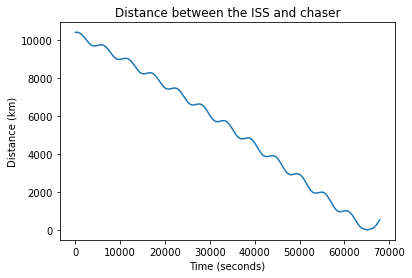

In [8]:
dist = np.linalg.norm(pos2d_c - pos2d_iss, axis=0)
print(f"Minimum distance={min(dist)*1000:.0f}m")
plt.plot(ts, dist)
plt.title("Distance between the ISS and chaser")
plt.xlabel("Time (seconds)")
plt.ylabel("Distance (km)")
plt.show()

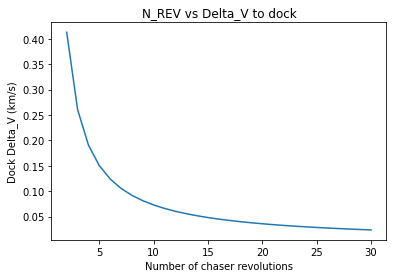

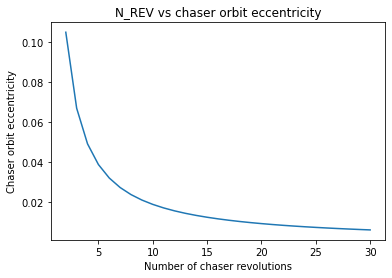

In [9]:
# 3.c
N_REVS = list(range(2, 30 + 1))

delta_vs = []
es_chaser = []
for N_REV in N_REVS:
    # calculate a and e
    a_chaser = np.power(1 - D_THETA / (2 * np.pi * N_REV), 2/3) * R_ISS
    es_chaser.append(R_ISS / a_chaser - 1)

    # calculate velocity at apogee
    v_abs_c = np.sqrt(G_EARTH * (2/R_ISS - 1/a_chaser))

    delta_vs.append(np.abs(V_ISS - v_abs_c))

plt.plot(N_REVS, delta_vs)
plt.title("N_REV vs Delta_V to dock")
plt.xlabel("Number of chaser revolutions")
plt.ylabel("Dock Delta_V (km/s)")
plt.show()

plt.plot(N_REVS, es_chaser)
plt.title("N_REV vs chaser orbit eccentricity")
plt.xlabel("Number of chaser revolutions")
plt.ylabel("Chaser orbit eccentricity")
plt.show()

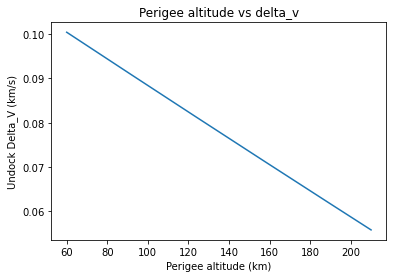

In [10]:
# apogee unchanged: r_apogee = R_ISS
# for perigee = 60 km altitude
h_pers = np.arange(60, 210 + 1)
r_per = R_EARTH + h_pers
a_lower_per = (r_per + R_ISS) / 2
v_apogee = np.sqrt(G_EARTH * (2/R_ISS - 1/a_lower_per))
delta_vs_lower_per = np.abs(V_ISS - v_apogee)

plt.plot(h_pers, delta_vs_lower_per)
plt.title("Perigee altitude vs delta_v")
plt.xlabel("Perigee altitude (km)")
plt.ylabel("Undock Delta_V (km/s)")
plt.show()